# Fichier de démonstration :

- Instancier les modèles
- Inférer sur les données de test
- divers: évaluer, comparer..

In [ ]:
# chemin = "votre chemin"
# from google.colab import drive
# drive.mount('/content/drive')
# wd = chemin
# import os
# fixer le repertoire de travail
# os.chdir(wd)

Mounted at /content/drive


In [ ]:
# installer la librairie segmentation-models-pytorch
# ! pip install segmentation-models-pytorch

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━

# 1- Instancier les modèles avec les poids sauvegardés
Pour faciliter le reproduction, voici le code pour instancier chaque modèle à partir des classes définies dans les fichiers d'architecture et d'entrainement.
Le choix est fait de reprendre les poids de la meilleure performance IoU, mais vous pouvez aussi bien utiliser les divers checkpoints sauvegardés et disponibles pour chaque modèle.

## 1.1. U-NET original

**Instancier le modèle avec les poids de la meilleure perf IoU**

In [ ]:
import os
from torch.utils.data import DataLoader



# Importer la classe OriginalUnet les composantes necéssaires
from scripts.UNET import (
    OriginalUNet, ChestXrayDataset,
    CLASSES, DEVICE, BATCH_SIZE,
    TEST_IMAGES_DIR, TEST_MASKS_DIR,
    get_transforms
)

# Importer les fonctions nécessaires de notre boite à outils
from scripts.utils.outils import (
    load_model,
    batch_inference
)

# Définir le chemin de sauvegarde de nos resultats
OUTPUT_DIR = "results/UNET"

# Charger le modèle à partir du checkpoint
model_UNET = load_model(
    model_class=OriginalUNet,
    checkpoint_path=os.path.join(OUTPUT_DIR, 'best_model_iou.pth'),
    device=DEVICE,
    in_channels=3,
    num_classes=CLASSES+1
)

print(f"Modèle chargé avec succès sur {DEVICE}!")


**Inférence sur le jeu de test**

In [ ]:
# Préparer le jeu de test
test_transform = get_transforms() # Appliquer les mêmes transformations
test_dataset = ChestXrayDataset(TEST_IMAGES_DIR, TEST_MASKS_DIR, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Jeu de test chargé: {len(test_dataset)} images")

# Définir les couleurs pour la visualisation
class_colors = [
    [0, 0, 0],        # Fond - noir
    [0, 128, 0],      # Poumon droit - vert
    [128, 0, 0],      # Poumon gauche - rouge
    [0, 0, 255]       # Cœur - bleu
]

# Définirn le repertoire de stockage des résultats
eval_dir = os.path.join(OUTPUT_DIR, "test_evaluation")
os.makedirs(eval_dir, exist_ok=True)

# Lancer une inférence sur tout le dossier test ( fonction batch_inférence dédiée dans notre boite à outils)
metrics_summary, metrics_table = batch_inference(
    model=model_UNET,
    dataloader=test_loader,
    device=DEVICE,
    output_dir=eval_dir,
    save_visualizations=True,  # Mettre à False pour ne pas sauvegarder les visualisations
    class_colors=class_colors,
    alpha=0.4  # Transparence pour les superpositions
)

# Afficher un aperçu du tableau des métriques
print("\n=== Aperçu des métriques par image ===")
print(metrics_table.head())

# Afficher les résultats sommaires
print("\n=== Résultats d'évaluation sommaires ===")
print(f"IoU moyen: {metrics_summary['mean_iou']:.4f}")
print(f"Dice moyen: {metrics_summary['mean_dice']:.4f}")
print(f"Accuracy pixel: {metrics_summary['pixel_accuracy']:.4f}")
print("IoU par classe:")
for i, iou in enumerate(metrics_summary['iou_per_class']):
    class_name = ["Fond", "Poumon droit", "Poumon gauche", "Cœur"][i]
    print(f"  - {class_name}: {iou:.4f}")

# Code pour prédire une image spécifique

"""
image_path = "path/to/specific/image.png"
pred_mask, original_image = predict_image(
    model=model,
    image_path=image_path,
    transform=get_transforms(),
    device=DEVICE
)

# Visualiser la prédiction
visualize_prediction(
    pred_mask=pred_mask,
    original_image=original_image,
    output_path=os.path.join(OUTPUT_DIR, "prediction_example.png"),
    class_colors=class_colors
)
"""

print("Traitement terminé!")

Jeu de test chargé: 32 images


Évaluation: 100%|██████████| 2/2 [00:14<00:00,  7.11s/it]


=== Aperçu des métriques par image ===
  filename  pixel_accuracy  mean_iou  mean_dice  iou_Fond  dice_Fond  \
0  image_0        0.953373  0.842030   0.911545  0.945977   0.972239   
1  image_1        0.952591  0.859648   0.923411  0.942162   0.970220   
2  image_2        0.971268  0.928880   0.962772  0.954887   0.976923   
3  image_3        0.974197  0.931627   0.964383  0.962403   0.980841   
4  image_4        0.954060  0.891674   0.942535  0.936827   0.967383   

   iou_Poumon droit  dice_Poumon droit  iou_Poumon gauche  dice_Poumon gauche  \
0          0.880138           0.936248           0.842622            0.914590   
1          0.845323           0.916179           0.775661            0.873659   
2          0.954165           0.976545           0.937789            0.967896   
3          0.948658           0.973652           0.927312            0.962286   
4          0.874267           0.932916           0.874479            0.933037   

   iou_Coeur  dice_Coeur  
0   0.699384 

## 1.2. RESNET_UNET

Ici nous utilisons directement notre fonction create_model (définie dans le script du modèle) et la librairie segmentation_models_pytorch pour Instancier le modèle

In [ ]:
import torch
import os
from torch.utils.data import DataLoader

# Importer les composantes nécessaires du script ResNet
from scripts.ResnetUNET import (
    ChestXrayDataset, create_model,
    CLASSES, DEVICE, BATCH_SIZE, BACKBONE,
    TEST_IMAGES_DIR, TEST_MASKS_DIR,
    get_transforms
)

# Importer les fonctions nécessaires de notre boite à outils
from scripts.utils.outils import (
    batch_inference
)

# Définir le chemin de sauvegarde de nos résultats
OUTPUT_DIR = "results/ResnetUNET"


# Utiliser directement create_model puis charger les poids
model_ResNet = create_model(num_classes=CLASSES, backbone_name=BACKBONE, freeze_encoder=True)
model_ResNet = model_ResNet.to(DEVICE)
checkpoint_path = os.path.join(OUTPUT_DIR, 'best_model_iou.pth')
model_ResNet.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE)) # Affecter les poids voulus
model_ResNet.eval()  # Mettre en mode évaluation
print(f"Modèle U-Net avec backbone {BACKBONE} chargé avec succès sur {DEVICE}!")

**Inférence sur le jeu de test**  

In [ ]:
# Préparer le jeu de test
test_transform = get_transforms()
test_dataset = ChestXrayDataset(TEST_IMAGES_DIR, TEST_MASKS_DIR, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Jeu de test chargé: {len(test_dataset)} images")

# Définir les couleurs pour la visualisation
class_colors = [
    [0, 0, 0],        # Fond - noir
    [0, 128, 0],      # Poumon droit - vert
    [128, 0, 0],      # Poumon gauche - rouge
    [0, 0, 255]       # Cœur - bleu
]


# Définir le dossier de sauvegarde
eval_dir = os.path.join(OUTPUT_DIR, "test_evaluation")
os.makedirs(eval_dir, exist_ok=True)

metrics_summary, metrics_table = batch_inference(
    model=model_ResNet,
    dataloader=test_loader,
    device=DEVICE,
    output_dir=eval_dir,
    save_visualizations=True,
    class_colors=class_colors,
    alpha=0.4  # Transparence pour les superpositions
)

# Afficher un aperçu du tableau des métriques
print("\n=== Aperçu des métriques par image ===")
print(metrics_table.head())

# Afficher les résultats sommaires
print("\n=== Résultats d'évaluation sommaires ===")
print(f"IoU moyen: {metrics_summary['mean_iou']:.4f}")
print(f"Dice moyen: {metrics_summary['mean_dice']:.4f}")
print(f"Accuracy pixel: {metrics_summary['pixel_accuracy']:.4f}")
print("IoU par classe:")
for i, iou in enumerate(metrics_summary['iou_per_class']):
    class_name = ["Fond", "Poumon droit", "Poumon gauche", "Cœur"][i]
    print(f"  - {class_name}: {iou:.4f}")

Jeu de test chargé: 32 images


Évaluation: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


=== Aperçu des métriques par image ===
  filename  pixel_accuracy  mean_iou  mean_dice  iou_Fond  dice_Fond  \
0  image_0        0.974056  0.908707   0.951377  0.968462   0.983978   
1  image_1        0.952629  0.856623   0.921415  0.942111   0.970193   
2  image_2        0.973412  0.935802   0.966700  0.959155   0.979152   
3  image_3        0.976845  0.933363   0.965082  0.968034   0.983757   
4  image_4        0.955975  0.897388   0.945747  0.938195   0.968112   

   iou_Poumon droit  dice_Poumon droit  iou_Poumon gauche  dice_Poumon gauche  \
0          0.936805           0.967371           0.901174            0.948019   
1          0.867527           0.929065           0.757864            0.862255   
2          0.956679           0.977860           0.917166            0.956794   
3          0.963383           0.981350           0.934290            0.966029   
4          0.878227           0.935166           0.878872            0.935531   

   iou_Coeur  dice_Coeur  
0   0.828388 

## 1.3 TRANSUNET

In [ ]:
import torch
import os
from torch.utils.data import DataLoader

# Importer les composantes nécessaires du script TransUNet
from scripts.TransUNET import (
    TransUNet, ChestXrayDataset,
    CLASSES, DEVICE, BATCH_SIZE, IMG_SIZE,
    TEST_IMAGES_DIR, TEST_MASKS_DIR,
    get_transforms
)

# Importer les fonctions utilitaires
from scripts.utils.outils import (
    batch_inference
)

# Définir le chemin de sauvegarde des résultats
OUTPUT_DIR = "results/TransUNET"

# Créer le modèle TransUNet
model_TransUNet = TransUNet(
    in_channels=3,
    num_classes=CLASSES+1,
    img_size=IMG_SIZE,
    patch_size=16,
    embed_dim=256,
    depth=4,
    num_heads=8,
    mlp_ratio=4.,
    qkv_bias=True
)
model_TransUNet = model_TransUNet.to(DEVICE)

# Charger les poids du modèle
checkpoint_path = os.path.join(OUTPUT_DIR, 'best_model_iou.pth')
model_TransUNet.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
model_TransUNet.eval()  # Mettre en mode évaluation

print(f"Modèle TransUNet chargé avec succès sur {DEVICE}!")

**Inférence sur le jeu de test**

In [ ]:
# Préparer le jeu de test
test_transform = get_transforms()
test_dataset = ChestXrayDataset(TEST_IMAGES_DIR, TEST_MASKS_DIR, transform=test_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Jeu de test chargé: {len(test_dataset)} images")

# Définir les couleurs pour la visualisation
class_colors = [
    [0, 0, 0],        # Fond - noir
    [0, 128, 0],      # Poumon droit - vert
    [128, 0, 0],      # Poumon gauche - rouge
    [0, 0, 255]       # Cœur - bleu
]



# Définir le dossier sauvegarde
eval_dir = os.path.join(OUTPUT_DIR, "test_evaluation")
os.makedirs(eval_dir, exist_ok=True)

metrics_summary, metrics_table = batch_inference(
    model=model_TransUNet,
    dataloader=test_loader,
    device=DEVICE,
    output_dir=eval_dir,
    save_visualizations=True,
    class_colors=class_colors,
    alpha=0.4  # Transparence pour les superpositions
)

# Afficher un aperçu du tableau des métriques
print("\n=== Aperçu des métriques par image ===")
print(metrics_table.head())

# Afficher les résultats sommaires
print("\n=== Résultats d'évaluation sommaires ===")
print(f"IoU moyen: {metrics_summary['mean_iou']:.4f}")
print(f"Dice moyen: {metrics_summary['mean_dice']:.4f}")
print(f"Accuracy pixel: {metrics_summary['pixel_accuracy']:.4f}")
print("IoU par classe:")
for i, iou in enumerate(metrics_summary['iou_per_class']):
    class_name = ["Fond", "Poumon droit", "Poumon gauche", "Cœur"][i]
    print(f"  - {class_name}: {iou:.4f}")

Jeu de test chargé: 32 images


Évaluation: 100%|██████████| 2/2 [00:14<00:00,  7.25s/it]


=== Aperçu des métriques par image ===
  filename  pixel_accuracy  mean_iou  mean_dice  iou_Fond  dice_Fond  \
0  image_0        0.974133  0.907535   0.950686  0.968918   0.984214   
1  image_1        0.933006  0.811755   0.893580  0.916953   0.956677   
2  image_2        0.981602  0.954482   0.976644  0.972124   0.985865   
3  image_3        0.980545  0.943540   0.970541  0.972321   0.985966   
4  image_4        0.959709  0.909122   0.952187  0.942126   0.970201   

   iou_Poumon droit  dice_Poumon droit  iou_Poumon gauche  dice_Poumon gauche  \
0          0.935398           0.966621           0.901354            0.948118   
1          0.726349           0.841485           0.726279            0.841439   
2          0.959060           0.979102           0.957743            0.978415   
3          0.967627           0.983547           0.956234            0.977627   
4          0.870890           0.930990           0.898248            0.946397   

   iou_Coeur  dice_Coeur  
0   0.824469 

# 2- Analyse quantitative

Une analyse quantitative se basant les résultats d'inférence est disponible dans le rapport de présentation dans la section "Résultats"

# 3- Analyse qualitative

### 3.1. Pires prédictions de UNET

U-Net Original - 3 pires cas:
    filename  mean_iou  pixel_accuracy
20  image_20  0.794539        0.896839
18  image_18  0.795698        0.927906
29  image_29  0.815208        0.925827


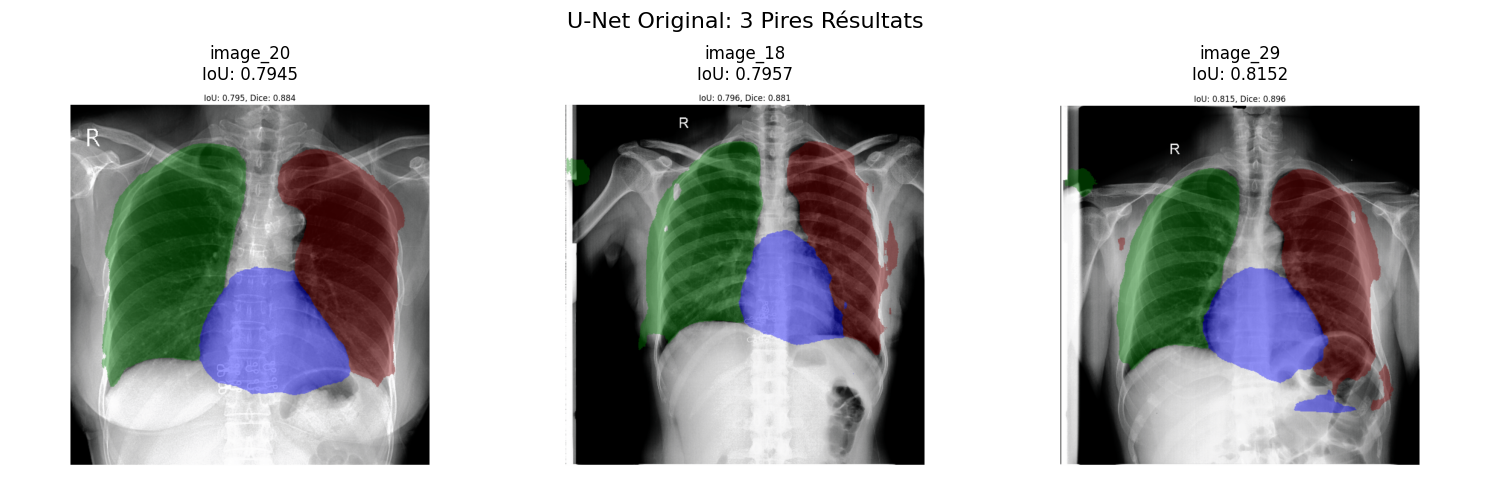

In [ ]:
# Analyse des 3 pires résultats pour U-Net Original
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les fichiers du modèle U-Net Original
unet_metrics_file = "results/UNET/test_evaluation/metrics_per_image.csv"
unet_visualizations_dir = "results/UNET/test_evaluation/visualizations"

# Charger les métriques
unet_metrics = pd.read_csv(unet_metrics_file)

# Trier par mean_iou croissant et prendre les 3 pires
worst_images = unet_metrics.sort_values(by='mean_iou').head(3)

# Afficher les métriques des 3 pires cas
print("U-Net Original - 3 pires cas:")
print(worst_images[['filename', 'mean_iou', 'pixel_accuracy']])

# Afficher les 3 pires images overlay
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(worst_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']

    # Charger l'image overlay
    overlay_path = os.path.join(unet_visualizations_dir, f"{image_name}_overlay.png")

    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}")
        plt.axis('off')

plt.suptitle("U-Net Original: 3 Pires Résultats", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### 3.2. Pires prédictions RESNET_UNET

U-Net+ResNet50 - 3 pires cas:
    filename  mean_iou  pixel_accuracy
15  image_15  0.775866        0.911907
20  image_20  0.823268        0.912685
28  image_28  0.834704        0.916386


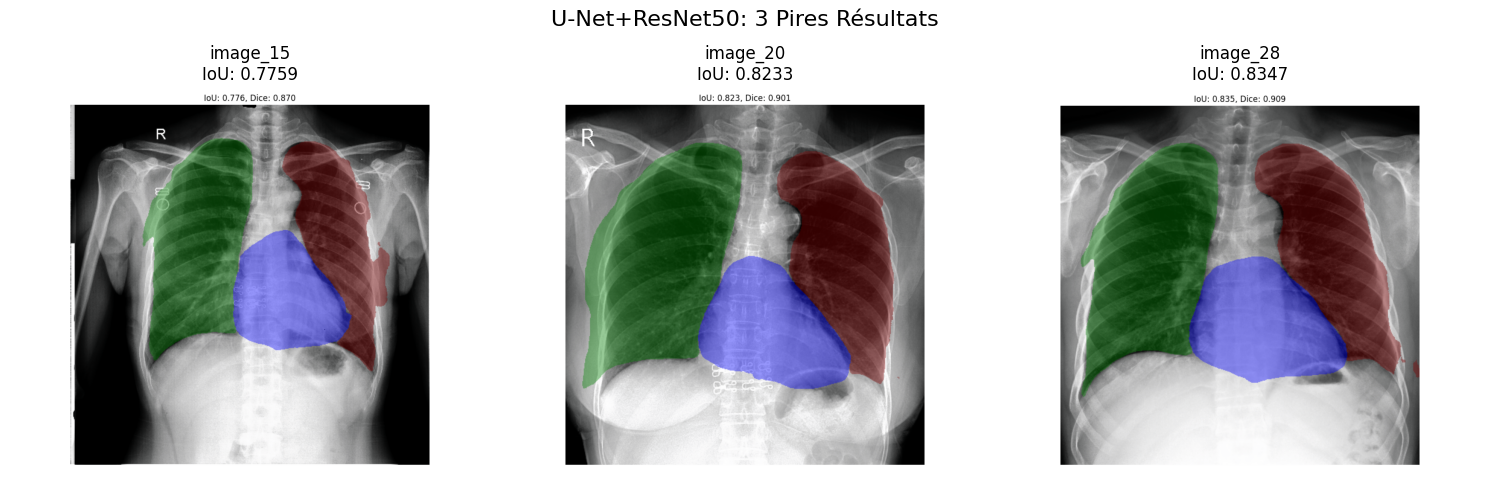

In [ ]:
# Analyse des 3 pires résultats pour U-Net+ResNet50
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les fichiers du modèle U-Net+ResNet50
resnet_metrics_file = "results/ResnetUNET/test_evaluation/metrics_per_image.csv"
resnet_visualizations_dir = "results/ResnetUNET/test_evaluation/visualizations"

# Charger les métriques
resnet_metrics = pd.read_csv(resnet_metrics_file)

# Trier par mean_iou croissant et prendre les 3 pires
worst_images = resnet_metrics.sort_values(by='mean_iou').head(3)

# Afficher les métriques des 3 pires cas
print("U-Net+ResNet50 - 3 pires cas:")
print(worst_images[['filename', 'mean_iou', 'pixel_accuracy']])

# Afficher les 3 pires images overlay
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(worst_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']

    # Charger l'image overlay
    overlay_path = os.path.join(resnet_visualizations_dir, f"{image_name}_overlay.png")

    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}")
        plt.axis('off')

plt.suptitle("U-Net+ResNet50: 3 Pires Résultats", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### 3.3. Pires prédictions TRANSUNET

In [ ]:
# Analyse des 3 pires résultats pour TransUNet
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les fichiers du modèle TransUNet
transunet_metrics_file = "results/TransUNET/test_evaluation/metrics_per_image.csv"
transunet_visualizations_dir = "results/TransUNET/test_evaluation/visualizations"

# Charger les métriques
transunet_metrics = pd.read_csv(transunet_metrics_file)

# Trier par mean_iou croissant et prendre les 3 pires
worst_images = transunet_metrics.sort_values(by='mean_iou').head(3)

# Afficher les métriques des 3 pires cas
print("TransUNet - 3 pires cas:")
print(worst_images[['filename', 'mean_iou', 'pixel_accuracy']])

# Afficher les 3 pires images overlay
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(worst_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']

    # Charger l'image overlay
    overlay_path = os.path.join(transunet_visualizations_dir, f"{image_name}_overlay.png")

    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}")
        plt.axis('off')

plt.suptitle("TransUNet: 3 Pires Résultats", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### 3.4. Meilleurs prédictions Unet

U-Net Original - 3 meilleures prédictions:
    filename  mean_iou  mean_dice  pixel_accuracy
17  image_17  0.940117   0.968912        0.978653
26  image_26  0.937591   0.967604        0.979221
27  image_27  0.935835   0.966796        0.972446


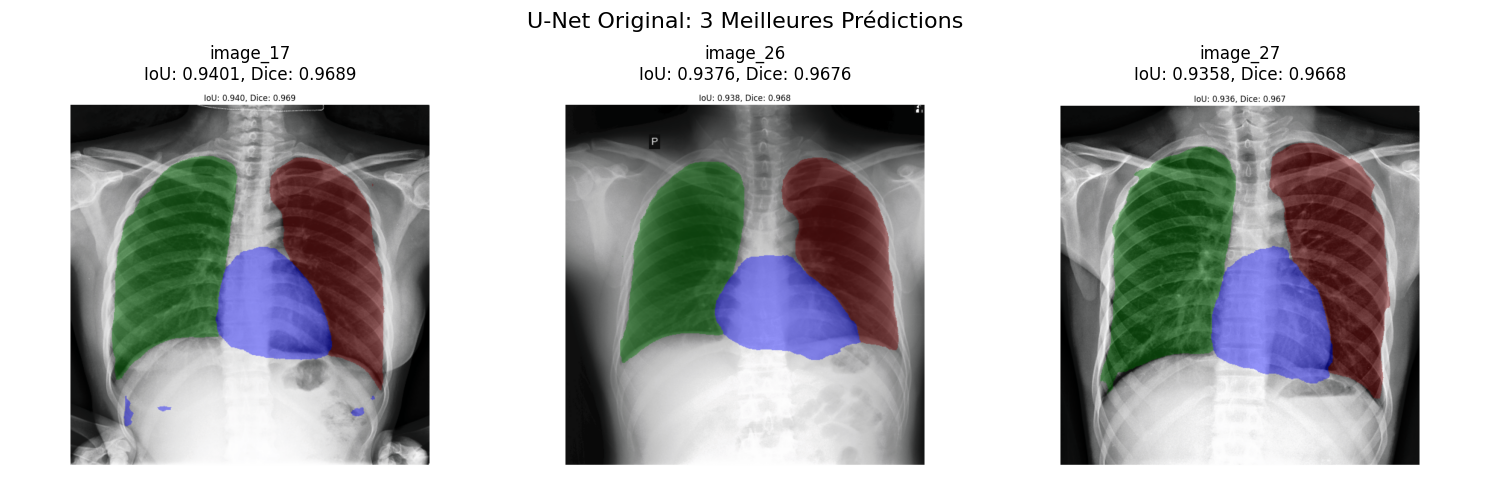

<Figure size 640x480 with 0 Axes>

In [ ]:
# U-Net Original - 3 meilleures prédictions
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les métriques et visualisations du U-Net Original
unet_metrics_file = "results/UNET/test_evaluation/metrics_per_image.csv"
unet_visualizations_dir = "results/UNET/test_evaluation/visualizations"

# Charger les métriques
unet_metrics = pd.read_csv(unet_metrics_file)

# Trier par mean_iou décroissant et prendre les 3 meilleurs
best_images = unet_metrics.sort_values(by='mean_iou', ascending=False).head(3)

# Afficher les métriques
print("U-Net Original - 3 meilleures prédictions:")
print(best_images[['filename', 'mean_iou', 'mean_dice', 'pixel_accuracy']])

# Préparer la visualisation
plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(best_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']
    dice_value = row['mean_dice']

    # Construire le chemin vers l'image overlay
    overlay_path = os.path.join(unet_visualizations_dir, f"{image_name}_overlay.png")

    # Vérifier si l'image existe
    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        # Afficher l'image
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}, Dice: {dice_value:.4f}")
        plt.axis('off')
    else:
        print(f"Image {overlay_path} non trouvée")

plt.suptitle("U-Net Original: 3 Meilleures Prédictions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Sauvegarder la figure pour inclusion dans le rapport
plt.savefig("best_unet.png", dpi=300, bbox_inches='tight')

### 3.5. Meilleurs prédictions RESNET-UNET

U-Net+ResNet50 - 3 meilleures prédictions:
    filename  mean_iou  mean_dice  pixel_accuracy
26  image_26  0.954706   0.976685        0.985474
17  image_17  0.954060   0.976343        0.984982
13  image_13  0.944510   0.971258        0.980106


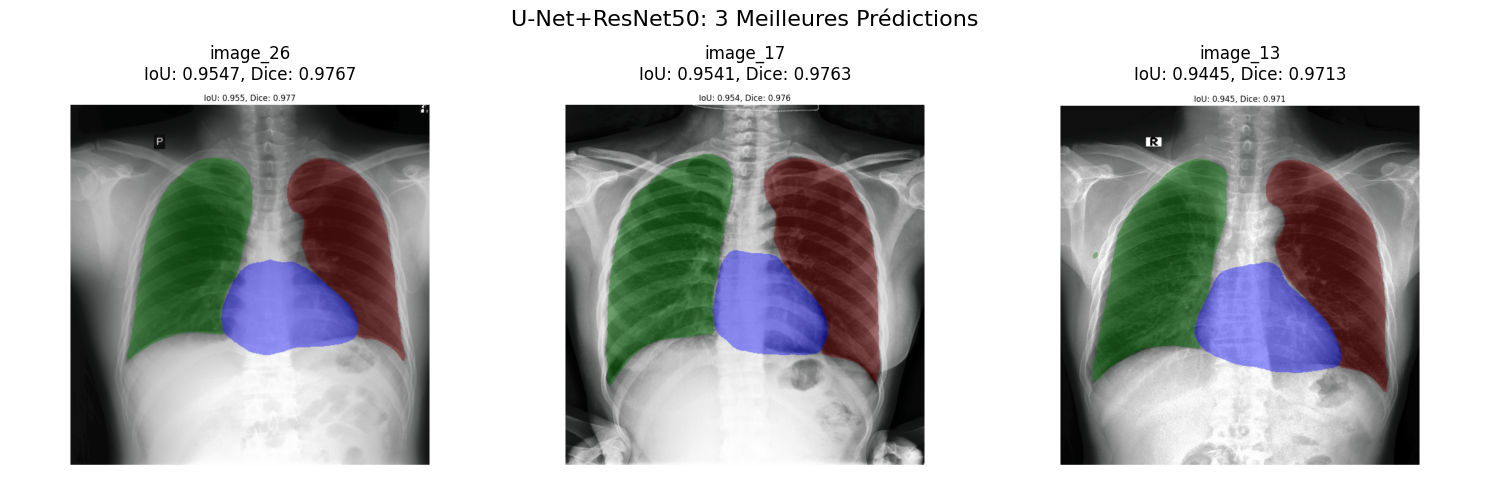

<Figure size 640x480 with 0 Axes>

In [ ]:
# U-Net+ResNet50 - 3 meilleures prédictions
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les fichiers du modèle U-Net+ResNet50
resnet_metrics_file = "results/ResnetUNET/test_evaluation/metrics_per_image.csv"
resnet_visualizations_dir = "results/ResnetUNET/test_evaluation/visualizations"

# Charger les métriques
resnet_metrics = pd.read_csv(resnet_metrics_file)

# Trier par mean_iou décroissant et prendre les 3 meilleurs
best_images = resnet_metrics.sort_values(by='mean_iou', ascending=False).head(3)

# Afficher les métriques
print("U-Net+ResNet50 - 3 meilleures prédictions:")
print(best_images[['filename', 'mean_iou', 'mean_dice', 'pixel_accuracy']])

# Préparer la visualisation
plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(best_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']
    dice_value = row['mean_dice']

    # Construire le chemin vers l'image overlay
    overlay_path = os.path.join(resnet_visualizations_dir, f"{image_name}_overlay.png")

    # Vérifier si l'image existe
    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        # Afficher l'image
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}, Dice: {dice_value:.4f}")
        plt.axis('off')
    else:
        print(f"Image {overlay_path} non trouvée")

plt.suptitle("U-Net+ResNet50: 3 Meilleures Prédictions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Sauvegarder la figure pour inclusion dans le rapport
plt.savefig("best_resnet.png", dpi=300, bbox_inches='tight')

### 3.6. Meilleurs prédictions TRANSUNET

In [ ]:
# TransUNet - 3 meilleures prédictions
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Chemin vers les fichiers du modèle TransUNet
transunet_metrics_file = "results/TransUNET/test_evaluation/metrics_per_image.csv"
transunet_visualizations_dir = "results/TransUNET/test_evaluation/visualizations"

# Charger les métriques
transunet_metrics = pd.read_csv(transunet_metrics_file)

# Trier par mean_iou décroissant et prendre les 3 meilleurs
best_images = transunet_metrics.sort_values(by='mean_iou', ascending=False).head(3)

# Afficher les métriques
print("TransUNet - 3 meilleures prédictions:")
print(best_images[['filename', 'mean_iou', 'mean_dice', 'pixel_accuracy']])

# Préparer la visualisation
plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(best_images.iterrows()):
    image_name = row['filename']
    iou_value = row['mean_iou']
    dice_value = row['mean_dice']

    # Construire le chemin vers l'image overlay
    overlay_path = os.path.join(transunet_visualizations_dir, f"{image_name}_overlay.png")

    # Vérifier si l'image existe
    if os.path.exists(overlay_path):
        img = Image.open(overlay_path)

        # Afficher l'image
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{image_name}\nIoU: {iou_value:.4f}, Dice: {dice_value:.4f}")
        plt.axis('off')
    else:
        print(f"Image {overlay_path} non trouvée")

plt.suptitle("TransUNet: 3 Meilleures Prédictions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Sauvegarder la figure pour inclusion dans le rapport
plt.savefig("best_transunet.png", dpi=300, bbox_inches='tight')

### 3.7. Un cas de succès avec GRAD-CAM ( image 26 dataset test => x_ray_158.png)

Couche cible trouvée: bottom.double_conv.0


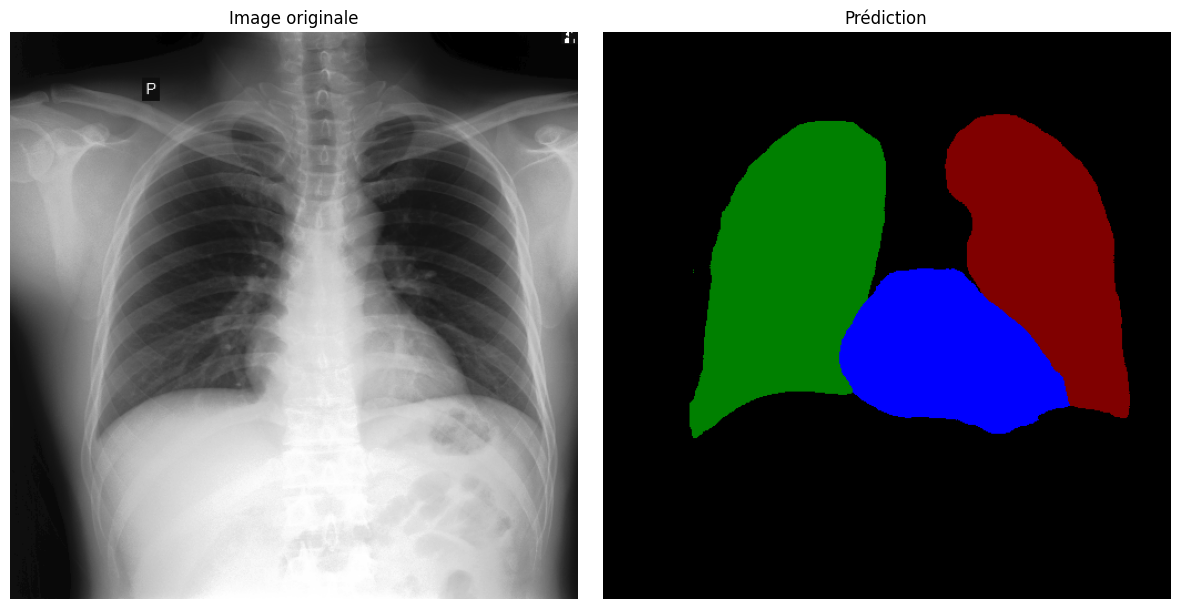

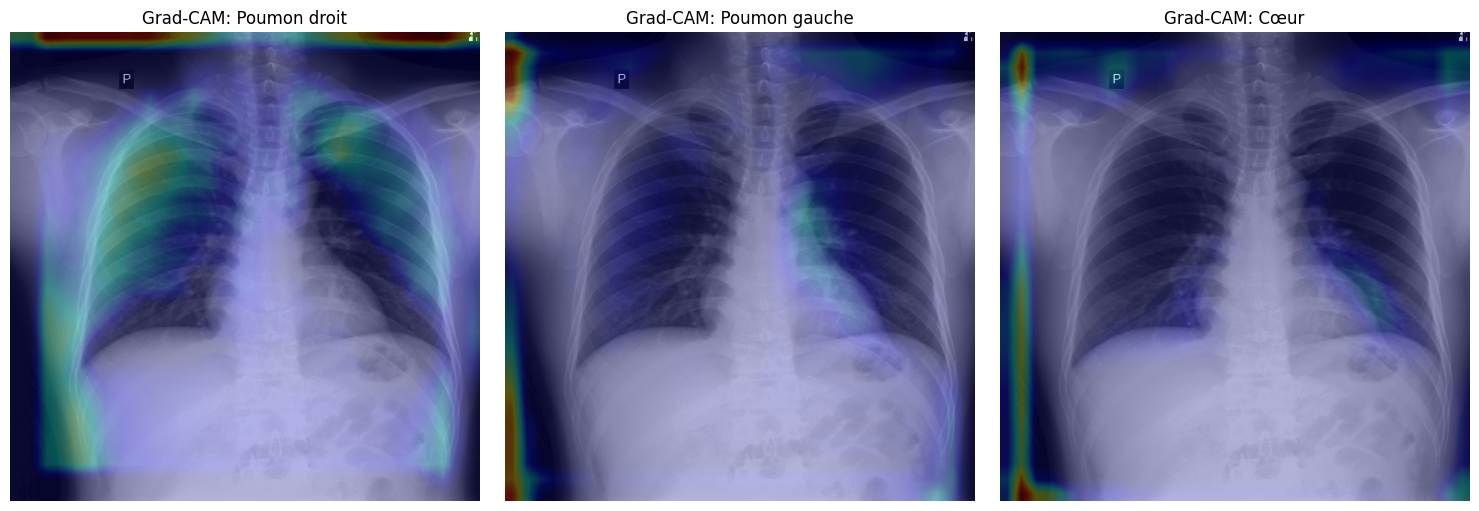

In [ ]:
# Application de Grad-CAM sur le U-Net Original pour l'image 26
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# On utilise le modèle déjà chargé: model_UNET
# Et les variables déjà définies: DEVICE, CLASSES, TEST_IMAGES_DIR, TEST_MASKS_DIR, get_transforms

# Classe pour appliquer Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []

        # Hook pour capturer les gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
            return None

        # Hook pour capturer les activations
        def forward_hook(module, input, output):
            self.activations = output
            return None

        # Enregistrer les hooks
        self.hooks.append(target_layer.register_backward_hook(backward_hook))
        self.hooks.append(target_layer.register_forward_hook(forward_hook))

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def __call__(self, input_tensor, class_idx):
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # Calculer la carte de segmentation pour la classe cible
        if output.dim() == 4:  # [B, C, H, W]
            # One-hot pour la classe cible
            target = torch.zeros_like(output)
            target[:, class_idx] = 1.0

            # Backprop
            self.model.zero_grad()
            output.backward(gradient=target, retain_graph=True)

            # Moyenner les gradients sur la dimension spatiale
            pooled_gradients = torch.mean(self.gradients, dim=[2, 3])

            # Multiplier chaque canal d'activation par son poids d'importance
            for i in range(self.activations.size(1)):
                self.activations[:, i, :, :] *= pooled_gradients[:, i].view(-1, 1, 1)

            # Moyenner les canaux pour obtenir la heatmap finale
            heatmap = torch.mean(self.activations, dim=1).squeeze().detach().cpu().numpy()

            # ReLU sur la heatmap
            heatmap = np.maximum(heatmap, 0)

            # Normaliser
            if np.max(heatmap) > 0:
                heatmap = heatmap / np.max(heatmap)

            return heatmap
        else:
            raise ValueError("Format de sortie inattendu")

# Trouver la couche cible pour Grad-CAM (fond du U)
target_layer = None
for name, module in model_UNET.named_modules():
    if isinstance(module, torch.nn.Conv2d) and module.out_channels == 1024:
        target_layer = module
        print(f"Couche cible trouvée: {name}")
        break

if target_layer is None:
    print("Couche cible non trouvée, utilisation du bottom")
    target_layer = model_UNET.bottom.double_conv[-2]  # Avant-dernière couche du fond du U

# Initialiser Grad-CAM
grad_cam = GradCAM(model_UNET, target_layer)

# Charger l'image 26
image_name = "xray_158.png"
image_path = os.path.join(TEST_IMAGES_DIR, image_name)



# Charger et prétraiter l'image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Appliquer les transformations
transform = get_transforms()
transformed = transform(image=original_image)
image_tensor = transformed["image"].unsqueeze(0).to(DEVICE)  # Ajouter dimension batch

# Charger aussi le masque pour référence
mask_path = os.path.join(TEST_MASKS_DIR, image_name)

# Vérifier si le masque existe
if not os.path.exists(mask_path):
    # Si le nom exact n'existe pas, chercher toute image commençant par "image_26"
    matching_files = [f for f in os.listdir(TEST_MASKS_DIR) if f.startswith("image_26")]
    if matching_files:
        mask_path = os.path.join(TEST_MASKS_DIR, matching_files[0])
        print(f"Masque trouvé: {matching_files[0]}")
    else:
        print(f"Aucun masque trouvé pour l'image 26, continuons sans masque de référence")
        mask_path = None

# Faire une prédiction pour référence
with torch.no_grad():
    pred = model_UNET(image_tensor)
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

# Visualiser la prédiction
class_colors = [
    [0, 0, 0],        # Fond - noir
    [0, 128, 0],      # Poumon droit - vert
    [128, 0, 0],      # Poumon gauche - rouge
    [0, 0, 255]       # Cœur - bleu
]
pred_color = np.zeros((pred.shape[0], pred.shape[1], 3), dtype=np.uint8)
for cls_idx, color in enumerate(class_colors):
    pred_color[pred == cls_idx] = color

# Créer une première figure avec l'image originale et la prédiction
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_color)
plt.title("Prédiction")
plt.axis('off')
plt.tight_layout()
plt.savefig("image26_prediction.png", dpi=300, bbox_inches='tight')
plt.show()

# Créer une figure séparée pour les heatmaps Grad-CAM
plt.figure(figsize=(15, 5))
class_names = ["Background", "Poumon droit", "Poumon gauche", "Cœur"]

# Nous visualisons les 3 classes importantes (pas le fond)
for i, (cls_idx, name) in enumerate(zip([1, 2, 3], ["Poumon droit", "Poumon gauche", "Cœur"])):
    # Générer la heatmap Grad-CAM pour cette classe
    heatmap = grad_cam(image_tensor, cls_idx)

    # Redimensionner la heatmap à la taille de l'image d'origine
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Convertir la heatmap en carte de couleurs
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Superposer la heatmap sur l'image originale
    superimposed = 0.7 * original_image + 0.3 * heatmap_colored
    superimposed = np.clip(superimposed / 255, 0, 1)

    # Ajouter au plot
    plt.subplot(1, 3, i+1)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM: {name}")
    plt.axis('off')

# Nettoyer les hooks
grad_cam.remove_hooks()

plt.tight_layout()
plt.savefig("gradcam_unet_xray126.png", dpi=300, bbox_inches='tight')
plt.show()